# SA Model Quantile Comparison

In [46]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy as sp
from pylab import *
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.algorithms import bipartite
import random as rd
from collections import Counter
import pylab 
import scipy.stats as stats
import warnings

from scipy.signal import savgol_filter


warnings.filterwarnings('ignore')

%matplotlib inline


# Model

In [47]:
#Function for drawing radial graphs in NetworkX library
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [48]:
#Counting the number of clusters and composition of cluster (cells per cluster)
def module_counter():
    global g
    cluster_counter=0
    for e in g.edges():
        if(g.edges[e[0],e[1]]['break']==0):
            cluster_counter=cluster_counter+1
            for n in g.nodes():
                if(n.endswith(e[1][1:])):
                    g.nodes[n]['clust']=str(cluster_counter)

In [49]:
#Calculation of Kullback-Leibler Divergence between the experimental and model derived distribution
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [50]:
#Count the distribution of number of cells per cluster
def count_freq(g):
    clust_information=[]
    for n in g.nodes():
        clust_information.append(g.nodes[n]['clust'])
    a=Counter(clust_information)
    freq=list(a.values())
    keys=list(a.keys())
    return freq,keys

In [51]:
def graph_snap(t,sim_time):
    for n in g.nodes():
        g.nodes[n]['snap_time']=int(str(n)[1])
    for e in g.edges():
        if(g.edges[e[0],e[1]]['break']==1):
            g.edges[e[0],e[1]]['snap_time']=int(e[1][1])-1
        else:
            g.edges[e[0],e[1]]['snap_time']=sim_time

In [52]:

def break_cluster(t,max_node):
    global g
    cluster_counter=0
    degree_list=[]
    
    for e in g.edges():
        if(t>=g.edges[e[0],e[1]]['t_break'] and (g.edges[e[0],e[1]]['break']!=0)):
            g.edges[e[0],e[1]]['break']=0


    node_list=[node for node in g.nodes()]
    for node in node_list:
        edges_temp=g.edges(node)
        break_list=[g.edges[ed[0],ed[1]]['break'] for ed in edges_temp]
        degree_list.append(sum(break_list))
    max_nodes = [node_list[i] for i, x in enumerate(degree_list) if x == max(degree_list)]
    max_degrees = [degree_list[i] for i, x in enumerate(degree_list) if x == max(degree_list)]
    
    for i,node in enumerate(max_nodes):
        if(max_degrees[i]>=max_node):
            edges=[edge for edge in g.edges(node) if g.edges[edge[0],edge[1]]['break']!=0]
            edge_bt=[g.edges[e[0],e[1]]['t_break'] for e in edges]
            for k,bt in enumerate(edge_bt): 
                if(np.round(bt,0)>=t):
                    edge_tbb=edges[k]
                    g.edges[edge_tbb[0],edge_tbb[1]]['break']=0    

        

In [53]:
def grow(t,mbt):
    global g
    nextg=g.copy()
    for n in g.nodes():
        new_node='Y'+str(t)+'_'+str(n)[1:] #Naming daughter cells to track lineage information
        nextg.add_edge(str(n),new_node) #Growth
        nextg.nodes[new_node]['clust']=nextg.nodes[str(n)]['clust'] #Inherit the cluster information
        nextg.edges[str(n),new_node]['break']=1
        nextg.edges[str(n),new_node]['t_break']=t+np.random.exponential(scale=mbt)
    g=nextg


In [54]:
def init_system():
    global g
    g=nx.Graph() #Initialization 
    g.add_node('Y0') #Mother yeast cell 
    g.nodes['Y0']['clust']='0'
    nextg=g.copy()

In [55]:
def fit_fun(x,a,b):
    y=(a*x)/(b+x)
    return y

In [56]:
#Main function to call other functions associated with dissociation of the cluster, counting of cells per custer
def clust_form_and_break(sim_time,max_node,mbt,dt,i):
    global g
    global arr
    init_system()
        
    for t in range(sim_time):
        if(int(t%dt)==0): 
            grow(t,mbt)
        break_cluster(t,max_node)
        graph_snap(t,sim_time)
        module_counter()
        if(t==i):
            freq1,keys1=count_freq(g)
        if(t==i+1):
            freq2,keys2=count_freq(g)
    
    df1=pd.DataFrame({'Keys':keys1,'Freq(t)':freq1})
    df2=pd.DataFrame({'Keys':keys2,'Freq(t+1)':freq2})
    
    return g,df1,df2

In [57]:
break_ratio=[]
mot=[]
prog=[]

for i in range(1000):
    g,a,b=clust_form_and_break(25,8,300,3,23)
    df_mix=a.merge(b)
    df_mix['Ratio']=df_mix['Freq(t+1)']/df_mix['Freq(t)']
    df_mix_filt=df_mix[df_mix['Freq(t)']>0]
    break_ratio.extend(list(df_mix_filt.loc[df_mix_filt['Ratio']<=0.5,'Ratio']))
    mot.extend(list(df_mix_filt.loc[df_mix_filt['Ratio']<=0.5,'Freq(t)']))
    prog.extend(list(df_mix_filt.loc[df_mix_filt['Ratio']<=0.5,'Freq(t+1)']))

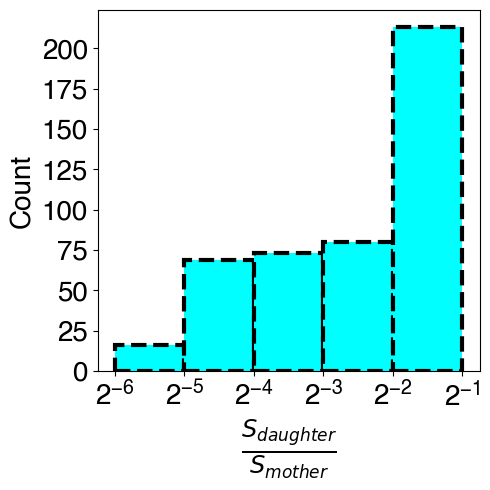

In [13]:
plt.rc('font',family='helvetica')
plt.figure(figsize=(5,5))
plt.hist(pd.Series(break_ratio),linestyle='--',bins=np.logspace(-6,-1,base=2,num=6),edgecolor='black',linewidth=3,color='cyan')
plt.xlabel(r'$\frac{S_{daughter}}{S_{mother}}$',fontsize=25)
plt.ylabel('Count',fontsize=20)
# plt.xlim([0.01,1.1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.text(2**-6,5,'n=28',fontsize=20)
plt.xscale('log',base=2)
plt.tight_layout()

# plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/Breaking_Dynamics_Fraction_Model.jpg',dpi=1200)

### 

From Simulation

In [58]:
f_sim,b=np.histogram(break_ratio,bins=np.logspace(-6,-1,base=2,num=6))
f_sim_norm=f_sim/sum(f_sim)

In [59]:
f_sim_norm

array([0.05698006, 0.17663818, 0.2022792 , 0.18518519, 0.37891738])

### From Experiment

In [60]:
f_exp=pd.read_csv('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Analysis/Ratio/ratio_exp.csv')['Freq']
f_exp_norm=f_exp/sum(f_exp)

In [61]:
f_exp_norm

0    0.037037
1    0.111111
2    0.222222
3    0.259259
4    0.370370
Name: Freq, dtype: float64

In [62]:
slope, intercept, r_value, p_value, std_err = stats.linregress(f_exp_norm,f_sim_norm)

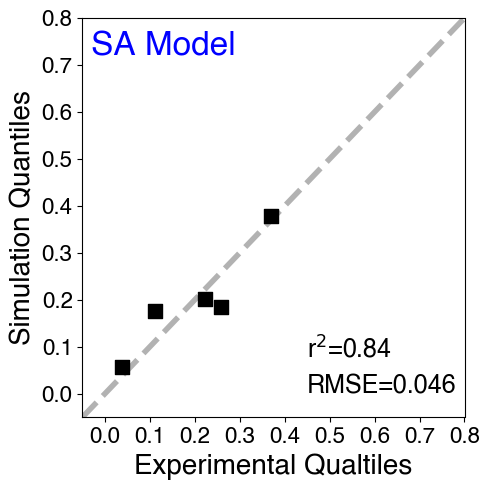

In [67]:

plt.rc('font',family='helvetica')
plt.figure(figsize=(5,5))

ul=0.8

plt.scatter(f_exp_norm,f_sim_norm,marker='s',color='black',s=100)
plt.plot([-0.05,ul],[-0.05,ul],linestyle='--',color='k',alpha=0.3,linewidth=4)
plt.xlim([-0.05,ul])
plt.ylim([-0.05,ul])
plt.xlabel('Experimental Qualtiles',fontsize=20)
plt.ylabel('Simulation Quantiles',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.xscale('log',base=2)
# plt.yscale('log',base=2)
mse=((f_exp_norm-f_sim_norm)**2).sum()/5
r='r$^2$='+str(round(r_value**2,2))
mse='RMSE='+str(round(np.sqrt(mse),3))
plt.text(0.45,0.075,r,fontsize=18)
plt.text(0.45,0.0,mse,fontsize=18)
plt.text(-0.03,0.72,'SA Model',fontsize=24,color='blue')

plt.tight_layout()
plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/SA_model_quantile_comprmse.png',dpi=600)

## Distribution of r2 values

In [20]:
r2_values=[]
mse_values=[]
for j in range(10):
    break_ratio=[]
    for i in range(1000):
        g,a,b=clust_form_and_break(25,8,1000,3,23)
        df_mix=a.merge(b)
        df_mix['Ratio']=df_mix['Freq(t+1)']/df_mix['Freq(t)']
        df_mix_filt=df_mix[df_mix['Freq(t)']>0]
        break_ratio.extend(list(df_mix_filt.loc[df_mix_filt['Ratio']<=0.5,'Ratio']))

    f_sim,b=np.histogram(break_ratio,bins=np.logspace(-6,-1,base=2,num=6))
    f_sim_norm=f_sim/sum(f_sim)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(f_exp_norm,f_sim_norm)
    mse=((f_exp_norm-f_sim_norm)**2).sum()/5

    r2_values.append(r_value)
    mse_values.append(mse)

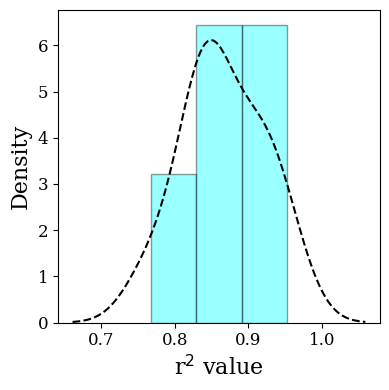

In [23]:
plt.rc('font',family='serif')
plt.figure(figsize=(4,4))
sns.distplot(r2_values,kde_kws=dict(color='black',linestyle='--'),hist_kws=dict(color='cyan',edgecolor='black'))
plt.xlabel('r$^{2}$ value',fontsize=16)
plt.ylabel('Density',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/sa_r2_dist.jpg',dpi=600)

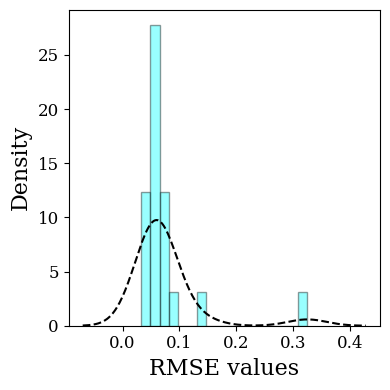

In [45]:
plt.rc('font',family='serif')
plt.figure(figsize=(4,4))
sns.distplot(np.sqrt(mse_values),kde_kws=dict(color='black',linestyle='--'),hist_kws=dict(color='cyan',edgecolor='black'))
plt.xlabel('RMSE values',fontsize=16)
plt.ylabel('Density',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.xlim(0,0.05)
plt.tight_layout()
plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/sa_rmse_dist.png',dpi=600)

## MSE sensitivity analysis with respect to link breaking rate

In [38]:
f_exp=pd.read_csv('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Analysis/Ratio/ratio_exp.csv')['Freq']
f_exp_norm=f_exp/sum(f_exp)

mse_values=[]
r_values=[]
for mbt in range(1,2001,100):
    break_ratio=[]
    for i in range(1000):
        g,a,b=clust_form_and_break(25,8,mbt,3,23)
        df_mix=a.merge(b)
        df_mix['Ratio']=df_mix['Freq(t+1)']/df_mix['Freq(t)']
        df_mix_filt=df_mix[df_mix['Freq(t)']>0]
        break_ratio.extend(list(df_mix_filt.loc[df_mix_filt['Ratio']<=0.5,'Ratio']))


    f_sim,b=np.histogram(break_ratio,bins=np.logspace(-6,-1,base=2,num=6))
    f_sim_norm=f_sim/sum(f_sim)
    slope, intercept, r_value, p_value, std_err = stats.linregress(f_exp_norm,f_sim_norm)
    mse=((f_exp_norm-f_sim_norm)**2).sum()/5
    mse_values.append(mse)
    r_values.append(r_value**2)

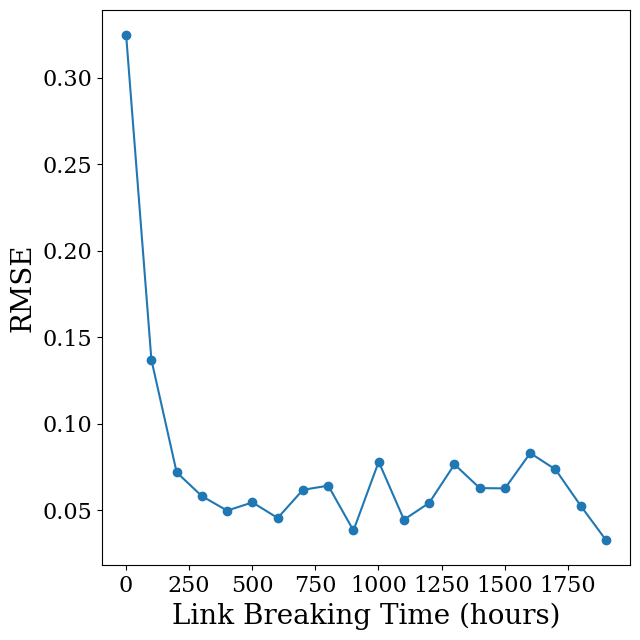

In [43]:
plt.figure(figsize=(6.5,6.5))
plt.plot(np.arange(1,2001,100),np.sqrt(mse_values))
plt.scatter(np.arange(1,2001,100),np.sqrt(mse_values))
plt.xlabel('Link Breaking Time (hours)',fontsize=20)
plt.ylabel('RMSE',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/mbt_sensitivity_sa.jpg',dpi=600)